In [1]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
from qwen_vl_utils import process_vision_info

In [2]:
model_path = "/data/data1/syc/intern/wanshan/models/Qwen2-VL-2B-Instruct"
min_pixels = 1344 * 28 * 28
max_pixels = 1680 * 28 * 28
device = 'cuda:2'

processor = Qwen2VLProcessor.from_pretrained(
            model_path,
            min_pixels=min_pixels,
            max_pixels=max_pixels,
        )
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    device_map=device,
).eval()

vit = model.visual

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [24]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "./chrome.png",
            },
            {
                "type": "text",
                "text": "Describe these images in details (more than 500 words).",
            },
        ],
    }
]
text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
image_inputs, video_inputs = process_vision_info(messages)

In [25]:
inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
inputs = inputs.to(device)
pixel_values = inputs['pixel_values']
image_grid_thw =  inputs['image_grid_thw']

In [26]:
with torch.no_grad():
    visual_tokens = vit(pixel_values, image_grid_thw)
    visual_tokens.shape

In [27]:
tokens_np = visual_tokens.cpu().numpy()

# 3. Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tokens_2d = tsne.fit_transform(tokens_np)



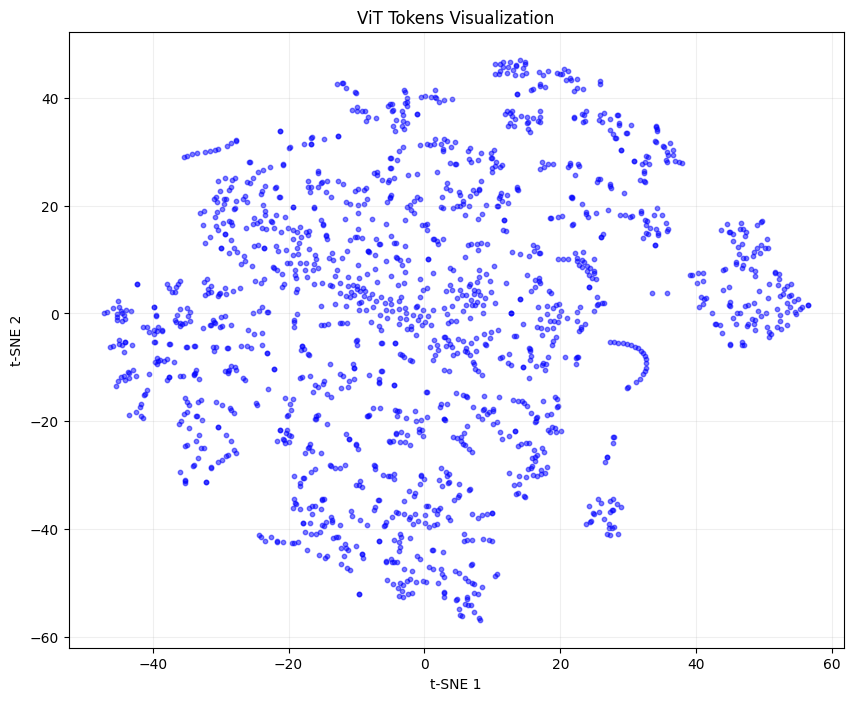

In [28]:
# 3. Plot with single color
plt.figure(figsize=(10, 8))
plt.scatter(tokens_2d[:, 0], tokens_2d[:, 1], 
            color='blue',  # single color
            alpha=0.5,    # semi-transparent
            s=10)        # point size
plt.title("ViT Tokens Visualization")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True, alpha=0.2)
plt.show()

In [29]:
from merge_2d import self_soft_matching_2d

selected_mask = self_soft_matching_2d(visual_tokens, r=0.1)
selected_mask = selected_mask.cpu()

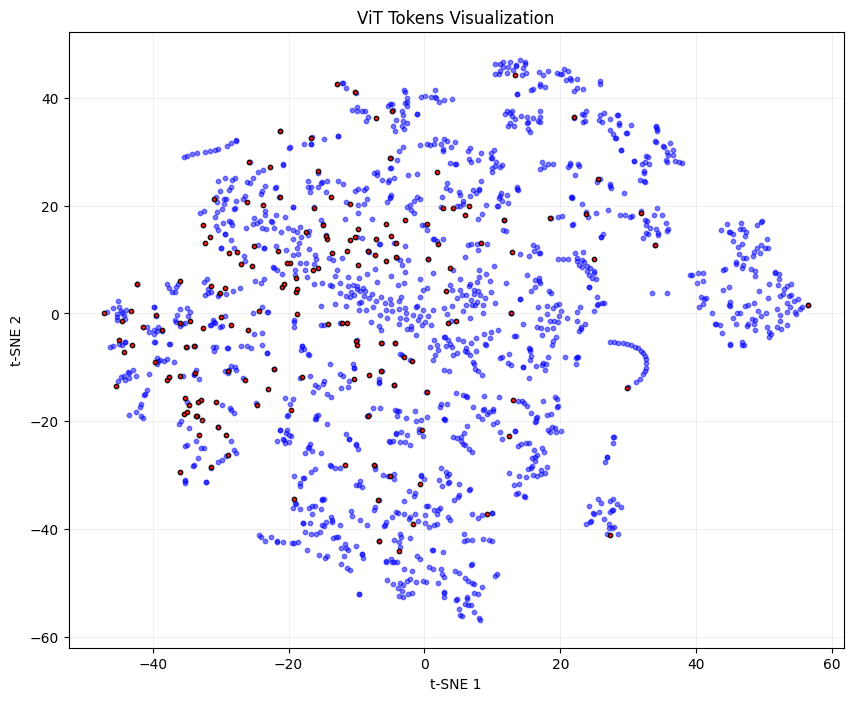

In [30]:
plt.figure(figsize=(10, 8))
plt.scatter(tokens_2d[~selected_mask, 0], tokens_2d[~selected_mask, 1], 
            color='blue',  # single color
            alpha=0.5,    # semi-transparent
            s=10)        # point size

plt.scatter(tokens_2d[selected_mask, 0], 
            tokens_2d[selected_mask, 1],
            color='red',
            alpha=0.9,
            s=10,
            label='Selected tokens',
            edgecolors='black')  # Add black border for better visibility

plt.title("ViT Tokens Visualization")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True, alpha=0.2)
plt.show()